# Etapa 1: Importação das bibliotecas

In [365]:
# Importing the necessary libraries:
import torch
from torch import nn, optim
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler    # Biblioteca para transformar os dados a escala ente 0-1 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import torch.nn.functional as F
torch.__version__
torch.manual_seed(123)

## Etapa 2: Base de dados

### Dado sintético


In [366]:
## Dado sintético 1 - organizado em serie temporal
data_length = 2049
zer=np.zeros((data_length,1))
for i in range(len(zer)): 
    zer[i] = 32 * math.pi*i/data_length
Dado_senoide = 4*np.sin(zer)

In [367]:
#plt.plot(Dado_senoide)
#plt.plot(zer[:],Dado_senoide[0], ".")

In [368]:
#Dado_senoide

### >>> Dado real

####               >>>>           Dado ações da Petrobras

In [369]:
Dado_petr4 = pd.read_csv('../../DADOS/petr4_treinamento.csv')
## 3.1 apagando linhas NAN
Dado_petr4 = Dado_petr4.dropna()
Dado_petr4 = Dado_petr4.iloc[:, 1:2].values

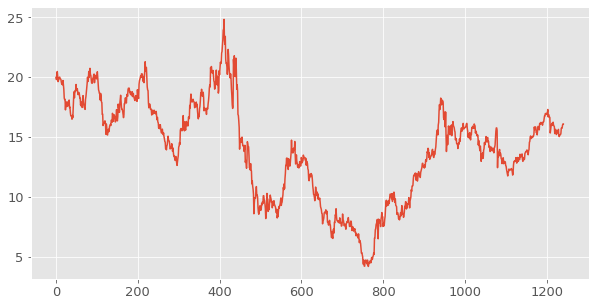

In [370]:
plt.plot(Dado_petr4)
#plt.plot(zer[:],Dado_senoide[0], ".")

#### >>>> Dado SOLAR

In [371]:
Dt = pd.read_excel("Serie_Dado_week.xlsx",index_col=0,header=0)#, names=['week'])# Lendo o arquivo            
del Dt['week']
#Dt.columns=['Date_day']
Dt.tail(10)


,RadGlobalCMP11 (W/m2)_mean
year_month_week,
2014-20,195743.081179
2014-21,200649.404140
2014-22,188638.109675
2014-3,293411.348572
2014-4,287073.567593
2014-5,292335.077550
2014-6,287379.338433
2014-7,291183.161359
2014-8,234384.352152


In [372]:
#Dt = pd.read_csv("/home/rodrigo/ENG_PRODUCAO/TCC/Redes-Neurais-Profundas_git_FELIPE/script/df_sem_outliers.csv",index_col=0,header=0, names=['solar_irradiation(w/m²)'])
#Dt = pd.read_excel("../Resultados_iniciais/Serie_Dado_hour.xlsx",index_col=0,header=0, names=['Date_hour'])# Lendo o arquivo            
Dt = pd.read_excel("Serie_Dado_week.xlsx",index_col=0,header=0)#, names=['week'])# Lendo o arquivo            
del Dt['week']
Dt.columns=['week']
Dt.head()
## 3.1 apagando linhas NAN
#Dt = Dt.dropna()
Dt=Dt[Dt["week"]>=1]
Dado_solar2=Dt[["week"]].values
Dado_solar=Dado_solar2[:,:].copy() 
#np.shape(Dado_solar)
Dt.head()
np.shape(Dt)

(53, 1)

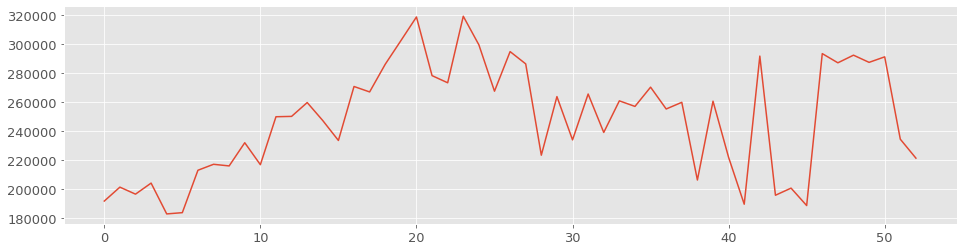

In [373]:
from pylab import rcParams
rcParams['figure.figsize'] = 16,4
plt.plot(Dado_solar[0:])
#plt.plot(zer[:],Dado_senoide[0], ".")

## Etapa 3: Processando os dados

In [374]:
#base_treinamento = Dado_petr4

In [375]:
base_treinamento = Dado_solar

In [376]:
#base_treinamento = Dado_senoide

In [377]:
np.shape(base_treinamento)

(53, 1)

## 3.1 apagando linhas NAN

base = base.dropna()
base.shape

## 3.2 Normalizando os dados entre 0-1

In [378]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
#base_treinamento_normalizada

## 3.3 Deslocando as lag da série pra obter X, e Y

In [379]:
lags=4 # Número de colunas x (valores do passado para prever o futuro)
input_dim=lags

X = []
y = []
for i in range(lags, len(base_treinamento_normalizada)):
    X.append(base_treinamento_normalizada[i-lags:i, 0])
    y.append(base_treinamento_normalizada[i, 0])
X, y = np.array(X), np.array(y)
np.shape(X),np.shape(y)

((49, 4), (49,))

## 3.4 Convertendo os dados para tensores

In [380]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

## 3.5 Concatenando X com Y

In [381]:
dataset = torch.zeros((len(y), lags+1)) #- Concatenando x e 
dataset[:,-1] = y
dataset[:,0:lags] = X
np.shape(dataset)

torch.Size([49, 5])

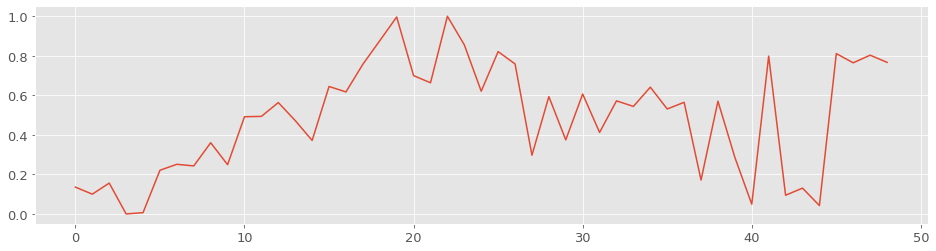

In [382]:
plt.plot(dataset[:,1])

## 3.6 Criando e inserindo labels 

## 3..6.7 Separando parte de treino e parte de teste

In [383]:
Percent_train=0.85
train_labels = torch.zeros(int(Percent_train*len(y)))
train_set = [(dataset[i], train_labels[i]) for i in range(int(Percent_train*len(y)))]
#################
del train_set
train_set = [(dataset[i], train_labels[i]) for i in range(37)]
#################

test_labels = torch.zeros(len(y)-int(Percent_train*len(y)))
test_set = dataset[int(Percent_train*len(y)):len(y),:]

np.shape(test_set)
#np.shape(train_set)

torch.Size([8, 5])

In [384]:
#train_set2 = dataset[0:37,:]
#plt.plot(train_set2[:,1])

## 3.4 Definindo mini batch para os dados

In [385]:
batch_size=int(len(train_labels)/1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
batch_size

41

# Etapa 4: Criação do modelo - GAN

## 4.1 Implementando o discriminador


### 4.1.1 - Discriminador Deep Learning Densa

In [386]:
print(" O input representa o número de colunas do X+y para modelar o rótulo 0 ou 1")
print(" A primeira camada do modelo discriminador deve ser preenchida com input=",lags+1)


 O input representa o número de colunas do X+y para modelar o rótulo 0 ou 1
 A primeira camada do modelo discriminador deve ser preenchida com input= 5


In [387]:
class DiscriminatorD(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Dropout(0.03),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.03),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        output = self.model(x)
        return output

discriminator=DiscriminatorD()

### 4.1.2 -  Discriminador Deep Learning Densa - curso

In [388]:
print(" O input representa o número de colunas do X+y para modelar o rótulo 0 ou 1")
print(" A primeira camada do modelo discriminador deve ser preenchida com input=",lags+1)


 O input representa o número de colunas do X+y para modelar o rótulo 0 ou 1
 A primeira camada do modelo discriminador deve ser preenchida com input= 5


In [389]:
class DiscriminatorD2(nn.Module):
    def __init__(self):
        super().__init__()
        # 784 -> 128 -> 64 -> 32 -> 1
        self.dense0 = nn.Linear(5, 128)
        self.dense1 = nn.Linear(128, 64)
        self.dense2 = nn.Linear(64, 32)
        self.dense3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, X):
        X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
        X = self.dense3(X)
        return X
D = DiscriminatorD2()

### 4.1.3 - Discriminador Deep RECORRENTE

## 4.2 Implementando o Gerador


### 4.2.1 - Gerador Deep Learning Densa

In [390]:
print(" O input representa o número de colunas do X para modelar 1 amostra y")
print(" A primeira camada do modelo gerador deve ser preenchida com input=",lags)


 O input representa o número de colunas do X para modelar 1 amostra y
 A primeira camada do modelo gerador deve ser preenchida com input= 4


In [391]:
class GeneratorD(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        output = self.model(x)
        return output
generator = GeneratorD()

### 4.2.2 -  Gerador Deep Learning Densa - curso

In [392]:
print(" O input representa o número de colunas do X para modelar 1 amostra y")
print(" A primeira camada do modelo gerador deve ser preenchida com input=",lags)

 O input representa o número de colunas do X para modelar 1 amostra y
 A primeira camada do modelo gerador deve ser preenchida com input= 4


In [393]:
class GeneratorD2(nn.Module):
    def __init__(self):
        super().__init__()
        # 100 -> 32 -> 64 -> 128 -> 784
        self.dense0 = nn.Linear(4, 32)
        self.dense1 = nn.Linear(32, 64)
        self.dense2 = nn.Linear(64, 128)
        self.dense22 = nn.Linear(128, 128)
        self.dense3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, X):
        X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense22(X), 0.2))        
        X = torch.tanh(self.dense3(X))
        #X = X.view(X.shape[0], 28, 28)
        return X
G = GeneratorD2()

### 4.2.3 - Gerador Deep RECORRENTE

## 4.3 Inicializando as peças

### 4.3.1 Definindo as peças

#### 4.3.1.1 Definindo as rede Gerador Discriminador 

In [394]:
discriminator=DiscriminatorD()
generator = GeneratorD()

#### 4.3.1.2 - Definindo os parâmetros do modelo

##### 4.3.1.2.1 - Pelo site

In [395]:
lr = 1e-3
lrD = 4e-4
lrG = 4e-4
num_epochs = 1000

loss_functionD = nn.BCELoss()
loss_functionG = nn.MSELoss()

criterion = nn.BCEWithLogitsLoss()

##### 4.3.1.2.2 - Pelo curso

#### 4.3.1.2 - Iinicializando os modelos

In [396]:
#SITE
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [397]:
# CURSO
G_optimizer = optim.Adam(G.parameters(), lr=lrG)
D_optimizer = optim.Adam(D.parameters(), lr=lrD)

In [398]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device
device=torch.device('cpu')

In [399]:
G.to(device)

GeneratorD2(
  (dense0): Linear(in_features=4, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=128, bias=True)
  (dense22): Linear(in_features=128, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [400]:
D.to(device)

DiscriminatorD2(
  (dense0): Linear(in_features=5, out_features=128, bias=True)
  (dense1): Linear(in_features=128, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

# 5 Treinamento do Modelo

## 5.1 Treinamento do Modelo Versão 1

### Crinado variável para acumular função erros ao longo das épocas.

In [401]:
import numpy as np
history_lossG = []
np.shape(history_lossG)

(0,)

## 5.1.2 LOOP DE TREINAMENTO - site

from pylab import rcParams
rcParams['figure.figsize'] = 10,3
yYreal=dataset[-250:,-1] 
xXreal=dataset[-250:,0:lags]

plt.plot(generator(xXreal).detach(), '-')
plt.plot(yYreal.detach(), '-')
np.shape(yYreal)


## 5.1.3 LOOP DE TREINAMENTO - curso

In [402]:
torch.manual_seed(101)
num_epochs=9000
for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (XYreal, _) in enumerate(train_loader):
        batch_size = XYreal.size(0)           # Tamanho da batch = Quantidade de amostras por batch
        XYreal = XYreal * 2 - 1               # Convertendo a base de dados para (-1,1) pq F.Tanh é nesse range
        XYreal = XYreal.to(device)            # Mandando a imagem para GPU
        
#######################################################################################
        Xreal = XYreal[:,0:lags].reshape(len(XYreal),lags)     # Pegando o x real
        Xreal = Xreal.to(device)                               # Mandando a imagem para GPU
        Yfake = G.forward(Xreal)                               # modelando y fake com o x 
#--------------------------------------------------------------------------------------        
# Treinamento do gerador - Stage 2 : MLP
#--------------------------------------------------------------------------------------
        Yreal = torch.ones((len(XYreal), 1)).to(device)
        Yreal[:,0] = XYreal[:,-1]
        Yfake = G.forward(Xreal)
        G_optimizer.zero_grad()              
        loss_generator_MLP = loss_functionG(Yfake, Yreal)
        loss_generator_MLP.backward(retain_graph=True)        
        G_optimizer.step()      

In [403]:
G.eval()

GeneratorD2(
  (dense0): Linear(in_features=4, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=128, bias=True)
  (dense22): Linear(in_features=128, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

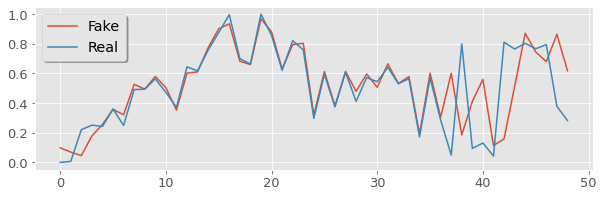

In [404]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,3
yYreal=dataset[:,-1] 
xXreal=dataset[:,0:lags]*2-1
xXreal=xXreal.to(device)
plt.plot((G.forward(xXreal).cpu().detach().numpy()+1)/2, '-',label='Fake')
plt.plot(yYreal.detach(), '-',label='Real')
np.shape(yYreal)
plt.legend(loc='upper left', shadow=True, fontsize='x-large')



0.10447022

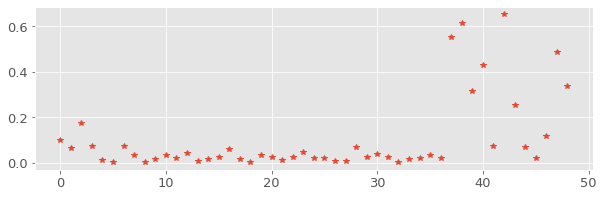

In [405]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,3
yYreal=dataset[-250:,-1] 
xXreal=dataset[-250:,0:lags]*2-1
xXreal=xXreal.to(device)
erro=(((G.forward(xXreal).cpu().detach().numpy()+1)/2))-((yYreal.detach().numpy().reshape(len(yYreal),1)))
plt.plot(abs(erro), '*')
abs(erro).mean()

# 6 Avaliação do modelo

## Bibliotecas necessárias - Felipe

## 6.1 Trabalhando com dados de VALIDAÇÃO - Teste

In [406]:
XV = test_set[:-1,:-1]#.reshape(len(XYreal),lags) 
yV = test_set[:-1,-1]
np.shape(XV),np.shape(yV)

(torch.Size([7, 4]), torch.Size([7]))

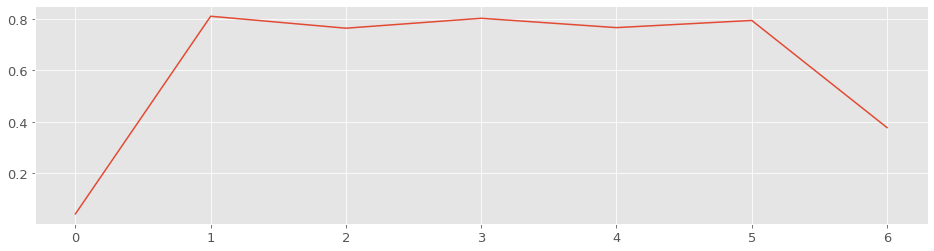

In [407]:
from pylab import rcParams
rcParams['figure.figsize'] = 16,4
plt.plot(yV[-150:])

## 6.5 Previsão

In [408]:
yV1=yV[:] 
XV1=XV[:,:]*2-1
XV1=XV1.to(device)
previsto=(((G.forward(XV1).cpu().detach().numpy()+1)/2))

## 6.6 Normalização inversa

In [409]:
Yprevisto=normalizador.inverse_transform(previsto)
Yreal=normalizador.inverse_transform(((yV1.detach().numpy().reshape(len(yV1),1))))

## 6.7 Avaliação dos resultados

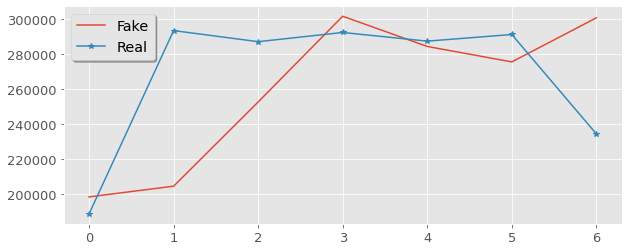

In [410]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,4
yV1=yV[:] 
XV1=XV[:,:]*2-1
XV1=XV1.to(device)
plt.plot(Yprevisto, '-',label='Fake')
plt.plot(Yreal, '-*',label='Real')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')

### 6.7.2 - Ánalise do erro absoludo 

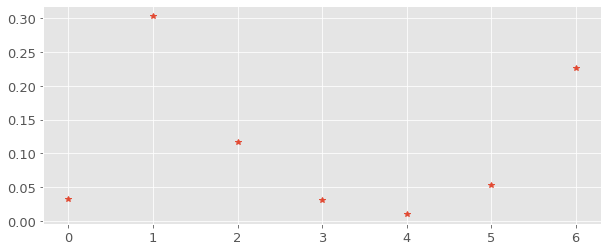

In [411]:
erro=Yprevisto-Yreal
plt.plot(abs(erro)/max(Yreal), '*')

### 6.7.2 - Calculo do erro absoludo médio

In [412]:
print("O modelo teve um erro absoluto médio de': %f%%" %  (((abs(erro)/max(abs(Yreal))).mean())*100) )

O modelo teve um erro absoluto médio de': 11.071576%


R² Coefficient of determination

R² Coefficient of determination actually works as a post metric, meaning it’s a metric that’s calculated using other metrics. 

The point of even calculating this coefficient is to answer the question “How much (what %) of the total variation in Y(target) is explained by the variation in X(regression line)”

This is calculated using the sum of squared errors. Let’s go through the formulation to understand it better.

Total variation in Y (Variance of Y):

Percentage of variation described the regression line:

Subsequently, the percentage of variation described the regression line:

Finally, we have our formula for the coefficient of determination, which can tell us how good or bad the fit of the regression line is:

This coefficient can be implemented simply using NumPy arrays in Python

In [413]:
# R^2 coefficient of determination
SE_line = sum((Yreal-Yprevisto)**2)
SE_mean = sum((Yreal-Yreal.mean())**2)
r2 = 1-(SE_line/SE_mean)
r2a=1-((len(Yreal)-1)/(len(Yreal)-(1+1))*(1-r2*r2))
r2a       
#print(f"R^2 coefficient of determination: {r2*100:0.2f}%")

array([-0.00741112], dtype=float32)

In [414]:
from sklearn.metrics import r2_score 
# em metrics, temos quase todas as metricas geralmete utilizadas

R2 = r2_score(Yreal,Yprevisto)
print(R2)    

-0.4006128050307971


In [415]:
def adjusted_r2(y_test, y_pred,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) / (len(y_test) - X_train.shape[1] - 1))
    return adj_r2

adjusted_r2(Yreal,Yprevisto,XV1)

-3.201838415092391

In [416]:
XV1.shape[1]

4

In [417]:
#Erro Percentual Absoluto Médio (MAPE)

In [418]:
import numpy as np

MAPE = np.mean(np.abs((Yreal - Yprevisto)/ (max(Yreal)+Yprevisto))) * 100

print(f"Valor do MAPE dado em percentual: {MAPE}")

Valor do MAPE dado em percentual: 6.021115556359291


# 8 Reorganizando dados adicionando header

In [419]:
Teste1=Dt[int(Percent_train*len(y)):len(y)]
Teste2=Dt[-len(Yprevisto):] 

### Adcicionando header nos dados 

In [420]:
interval=Teste2.index

predictions=pd.DataFrame(Yprevisto)
predictions['Date']=interval
predictions.set_index('Date', inplace=True)
predictions.columns=['fGAN']
#predictions.head()

Yreal_data=pd.DataFrame(Yreal)
Yreal_data['Date']=interval
Yreal_data.set_index('Date', inplace=True)
Yreal_data.columns=['Real']
#predictions.head()

concatenado_FAIXATESTE = pd.merge(predictions,Yreal_data, how = 'outer', on = 'Date')
concatenado_FAIXATESTE.columns=['fGAN','Real']

## Salvando os resultados

In [421]:
concatenado_FAIXATESTE.to_excel("Resultados_PseudfGAN_MLP/Serie_Dado_real_plu_PseudfGAN_MLP_weekly.xlsx")

## Plotando os resultados

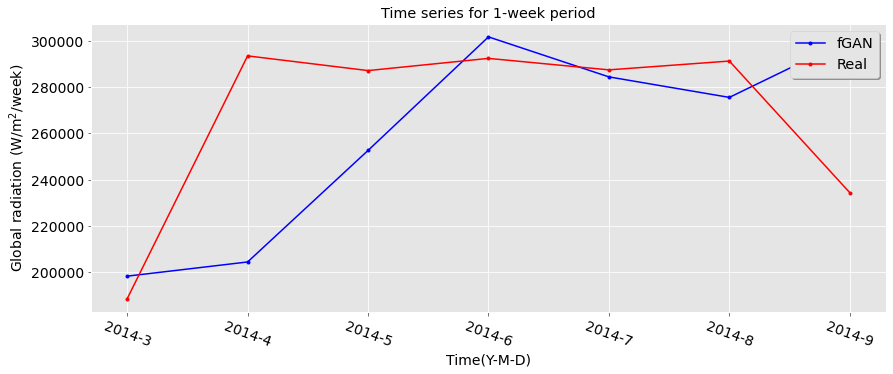

In [422]:
# Vamos plotar
########################################################################################
####          PLOTANDO OS RESULTADOS EM PDF
########################################################################################
#----------------------------------------------------------------------------------------------------------
# Vamos agora plotar tanto o modelo, a previsão e a série original.
import matplotlib 
matplotlib.rc('xtick', labelsize=13)  # Alterando a fonte 
matplotlib.rc('ytick', labelsize=13)  # Alterando a fonte 
plt.style.use('ggplot')
tick_spacing = 12

#----------------------------------------------------------------------------------------------------------
fig=plt.figure(figsize=(12,8))
ax=fig.add_axes([0.06, 0.12, 0.92, 0.5])
#---------------------------------------------------------------------------------------------------------
# Colocando toda a faixa de previsão e de modelagem
concatenado_FAIXATESTE['fGAN'].plot(ax=ax,marker='.', color='blue', legend=True, 
                                    title='Time series for 1-week period', fontsize=14)
#----------------------------------------------------------------------------------------------------------
# Colocando só a faixa de previsão
concatenado_FAIXATESTE['Real'].plot(ax=ax,marker='.', color='red', fontsize=14, legend=True)

plt.xticks(rotation = -20, fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.set_ylabel('Global radiation (W/m$^2/$week)', fontsize=14, color='black')
ax.set_xlabel('Time(Y-M-D)', fontsize=14, color='black')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

#fig.tight_layout()
fig.savefig("Resultados_PseudfGAN_MLP/Serie_Dado_real_plu_PseudfGAN_MLP_week.png", bbox_inches='tight')

In [423]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Yreal_data, predictions))
print('MSE:', metrics.mean_squared_error(Yreal_data, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Yreal_data, predictions)))

MAE: 32485.26
MSE: 1989412900.0
RMSE: 44602.836


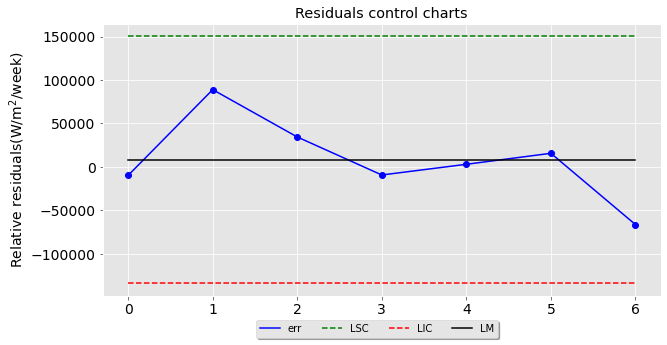

In [424]:
#def Carta_Controle1(predictions,test_Y2):
rcParams['figure.figsize'] = 10, 5
erro=pd.DataFrame
erro=Yreal_data['Real']- predictions['fGAN']
#erro.to_csv("/home/rodrigo/Dropbox/Estudando_IA/PIBIC_UFBA/erro_previsao_RBF3.csv")
def Carta_Controle1(erro):
    barra_erro=erro.mean()
    desvio_erroc=erro.std()
    LSC=[]
    LIC=[]
    LM=[]
    i=0
    while i <len(erro):
        LIC.append(barra_erro-3*desvio_erroc)
        LSC.append(barra_erro+3*desvio_erroc)
        LM.append(barra_erro)
        i+=1
    erroV=erro.values.astype('float32')
    fig, ax = plt.subplots(1,1)
    plt.plot(erroV, 'bo')
    plt.plot(erroV, 'b', label='err')
    plt.plot(LSC, 'g--', label='LSC')
    plt.plot(LIC, 'r--', label='LIC')
    plt.plot(LM, 'black', label='LM')
    plt.title('Residuals control charts')
    plt.yticks(fontsize=14, color='black')
    plt.xticks(fontsize=14, color='black')   
    ax.set_ylabel('Relative residuals(W/m$^2/$week)', fontsize=14, color='black')
    
    ax.legend(loc='upper left', bbox_to_anchor=(0.265, -0.07), shadow=True, ncol=4)
    fig.savefig('Resultados_PseudfGAN_MLP/Serie_Dado_real_plu_PseudfGAN_MLP_ERRO_week.pdf', format='pdf')
Carta_Controle1(erro)

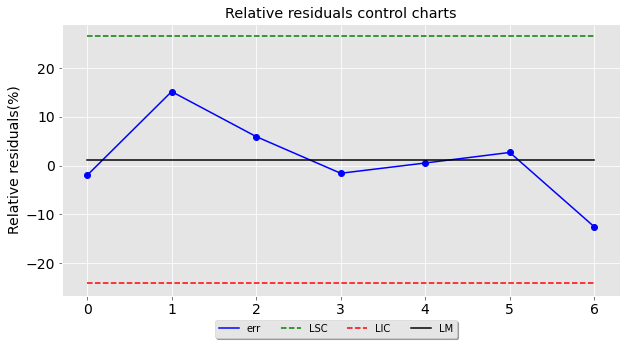

In [425]:
#def Carta_Controle1(predictions,test_Y2):
rcParams['figure.figsize'] = 10, 5
erro=pd.DataFrame
erro=(Yreal_data['Real']- predictions['fGAN'])/(max(Yreal_data['Real'])+Yreal_data['Real'])*100
#erro.to_csv("/home/rodrigo/Dropbox/Estudando_IA/PIBIC_UFBA/erro_previsao_RBF3.csv")
def Carta_Controle1(erro):
    barra_erro=erro.mean()
    desvio_erroc=erro.std()
    LSC=[]
    LIC=[]
    LM=[]
    i=0
    while i <len(erro):
        LIC.append(barra_erro-3*desvio_erroc)
        LSC.append(barra_erro+3*desvio_erroc)
        LM.append(barra_erro)
        i+=1
    erroV=erro.values.astype('float32')
    fig, ax = plt.subplots(1,1)
    plt.plot(erroV, 'bo')
    plt.plot(erroV, 'b', label='err')
    plt.plot(LSC, 'g--', label='LSC')
    plt.plot(LIC, 'r--', label='LIC')
    plt.plot(LM, 'black', label='LM')
    plt.title('Relative residuals control charts')
    plt.yticks(fontsize=14, color='black')
    plt.xticks(fontsize=14, color='black')   
    ax.set_ylabel('Relative residuals(%)', fontsize=14, color='black')

    ax.legend(loc='upper left', bbox_to_anchor=(0.265, -0.07), shadow=True, ncol=4)
    fig.savefig('Resultados_PseudfGAN_MLP/Serie_Dado_real_plu_PseudfGAN_MLP_week_percent.pdf', format='pdf')
Carta_Controle1(erro)